In [1]:
### TO-DOs ###

# Check that if I go back to original Damodaran estimates I still get the correct result
# Code a Monte Carlo simulation where each of the inputs is a distribution
# Plot the historical and projected trajectory with confidence intervals for each input
# Substitute each of hard-coded inputs for adequate cualculations
# Prepare this to be repeated at any point during the year and not just at year end (ttm calculations, etc.)

In [66]:
import requests
from urllib.parse import urlparse, urlunparse

import numpy as np
import numpy_financial as npf

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date

from itertools import accumulate
import operator


#financialmodellingprep.com API key
apikey = '6d5a44e82d49d8446e8db1914d12e2b4'
simfinkey = 'S54dNEScw70KAegQwNs46skHPfblWSoB'

In [67]:
valuation_date = date.fromisoformat('2020-06-01')
years_to_project = 5

monte_carlo_iterations = 1000

projected_years = [y for y in range(valuation_date.year,valuation_date.year+years_to_project)]
# Instead of years the dates should be 12 months from valuation date, and then 12 months later, etc.

## S&P500 Valuation
21 February 2021

#### Framework and key questions to answer
<img src="img/IndexValueFramework.jpg" width=360 align="left"/>

#### Story

---

**1. Earnings Growth**

**2. Cash Return**

**3. Risk Premium**

**4. Risk Free Rate**

In [68]:
hist_df = pd.read_excel('data/histimplERP.xls',sheet_name='Historical Impl Premiums',header=6,skipfooter=7)
hist_df.drop(hist_df.tail(1).index,inplace=True) #Temporary fix because using data file from 2021 and replicating valuation as if it was 2020

In [69]:
inputs_df = pd.DataFrame()
inputs_df['year'] = hist_df['Year']
inputs_df['ERP'] = hist_df['Implied Premium (FCFE)']
inputs_df['earnings'] = hist_df['Earnings*']
inputs_df['RFR'] = hist_df['T.Bond Rate']
inputs_df['div&bb'] = hist_df['Dividends + Buybacks']

# Keep adding historical values for all the other elements of the valuation

### Present the historical and projected for each input with the rational for projection

In [70]:
hist_df['% earnings returned'] = hist_df['Dividends + Buybacks']/hist_df['Earnings*']

<AxesSubplot:xlabel='Change in Earnings', ylabel='Count'>

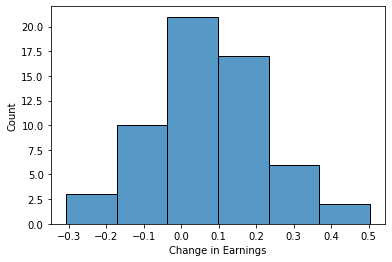

In [71]:
hist_df['Change in Earnings'].describe()
sns.histplot(data=hist_df, x="Change in Earnings",bins=6)

In [72]:
hist_df[hist_df['Year']>2000]['Change in Earnings'].describe()

count    19.000000
mean      0.070416
std       0.164165
min      -0.307857
25%      -0.017581
50%       0.094445
75%       0.172562
max       0.402515
Name: Change in Earnings, dtype: float64

### Calculations

In [90]:
# Original Damodaran estimates
#   future_earnings = np.array([120.0,150.0,160.83,172.45,184.91])
#      earnings_first_year = 120.0
#      earnings_growth = np.array([0.25,0.0722,0.0722,0.0722])

#   cash_returned = np.array([90.71,121.01,137.93,156.66,177.37])
#   cash_returned_percent = np.array([0.75591667, 0.80673333, 0.85761363, 0.90843723, 0.95922341])
#      percent_returned_first = 0.7559  # INTRODUCE RANDOMNESS
#      percent_returned_last = 0.9593   # INTRODUCE RANDOMNESS

#   equity_risk_premium = 5.58/100
#      ERP_random = np.repeat(5.58/100,monte_carlo_iterations)

outputs_df = pd.DataFrame()

# Generate all the rndom variables at once to then use inside the iteration
earnings_first_year_random = norm.rvs(loc=120,scale=5,size=monte_carlo_iterations)
earnings_growth_random = [norm.rvs(loc=7.04/100,scale=16/100,size=years_to_project-1) for year in range(0,monte_carlo_iterations)]    

ERP_random = np.random.uniform(5.02/100,6.14/100,monte_carlo_iterations)
#ERP_random = np.repeat(5.58/100,monte_carlo_iterations)

percent_returned_first = 0.7559  # INTRODUCE RANDOMNESS
percent_returned_last = 0.9593   # INTRODUCE RANDOMNESS


# What is below would be one iteration
for i in range(0,monte_carlo_iterations):

    earnings_first_year = earnings_first_year_random[i]
    earnings_growth = earnings_growth_random[i]
    growth_factor = [1] + list(accumulate(earnings_growth+1, operator.mul))
    future_earnings = np.repeat(earnings_first_year, years_to_project) * growth_factor

    percent_returned = np.linspace (start=percent_returned_first,stop=percent_returned_last,num=years_to_project)
    cash_returned = future_earnings * percent_returned 
    equity_risk_premium = ERP_random[i]
    risk_free_rate = 0.66/100 

    discount_rate = risk_free_rate + 1 * equity_risk_premium
    long_term_growth = risk_free_rate

    #Calculate intrinsic value of the index given estimates for input
    cash_flows = np.concatenate((np.array([0]),cash_returned)) # Add a "today" cash flow of 0 to make first cash flow in year 1
    cash_terminal = cash_returned[-1]*(1+long_term_growth)/(discount_rate - long_term_growth)
    cash_flows[-1] += cash_terminal

    intrinsic_index_level = npf.npv(discount_rate,cash_flows)
    d = [{'S&P500': intrinsic_index_level}]
    outputs_df = outputs_df.append(d,ignore_index=True,sort=False)

    # Create rows for projection
    d = {'year': projected_years, 
         'earnings': future_earnings,
         'div&bb': cash_returned,
         'RFR': [risk_free_rate]*years_to_project,
         'ERP': [equity_risk_premium]*years_to_project,
        }
    temp_df = pd.DataFrame(d)
    
    # Append new projection to output_df
    inputs_df = pd.concat([inputs_df,temp_df])

### OUT

<AxesSubplot:xlabel='year', ylabel='earnings'>

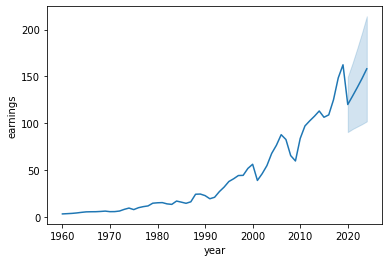

In [86]:
sns.lineplot(x="year", y="earnings",data=inputs_df,ci="sd")

<AxesSubplot:ylabel='S&P500'>

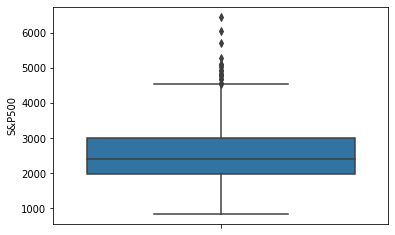

In [91]:
sns.boxplot(y="S&P500",
            data=outputs_df)

<AxesSubplot:xlabel='S&P500', ylabel='Count'>

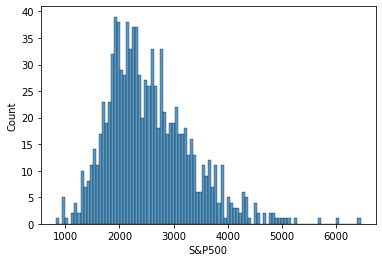

In [92]:
sns.histplot(data=outputs_df, x="S&P500", bins=100)

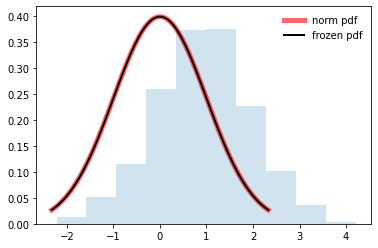

In [34]:
from scipy.stats import norm

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

mean, var, skew, kurt = norm.stats(moments='mvsk')

x = np.linspace(norm.ppf(0.01),norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),'r-', lw=5, alpha=0.6, label='norm pdf')

rv = norm()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

vals = norm.ppf([0.001, 0.5, 0.999])
np.allclose([0.001, 0.5, 0.999], norm.cdf(vals))

r = norm.rvs(loc=1,scale=1,size=1000)

ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

In [55]:
#for year in range(0,years_to_project):
#    r = norm.rvs(loc=1,scale=1,size=monte_carlo_iterations)

    
t = [norm.rvs(loc=1,scale=1,size=years_to_project) for year in range(0,monte_carlo_iterations)]    

In [60]:
t[10]
#earnings_growth

array([ 1.97333188,  2.49999924,  1.39833037, -0.24420663,  2.02744035])